In [23]:
import os
import shutil
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold

import cv2
import numpy as np

Data Preprocessing

Cropping images to remove unnecessary black background

In [18]:
def process_image(image_path, output_path, padding=10):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to create a binary mask
    _, binary_mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print(f"No contours found for image: {image_path}")
        return

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(contours[0])

    # Add padding to the bounding box
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(w + 2 * padding, image.shape[1] - x)
    h = min(h + 2 * padding, image.shape[0] - y)

    # Crop the image using the bounding box
    cropped_image = image[y:y+h, x:x+w]

    # Save the result
    cv2.imwrite(output_path, image)

# Function to process all images in a folder
def process_all_images(input_folder, output_folder):
    for root, _, files in os.walk(input_folder):
        for filename in files:
            if filename.lower().endswith('.jpg'):
                input_path = os.path.join(root, filename)
                relative_path = os.path.relpath(root, input_folder)
                output_dir = os.path.join(output_folder, relative_path)
                
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                
                output_path = os.path.join(output_dir, filename)
                process_image(input_path, output_path)
                print(f"Processed {filename} in {relative_path}")

# Define the input and output directories
input_folder = 'dataset_13'  # Change to your input folder path
output_folder = 'processed_dataset_13'  # Change to your output folder path

# Process all images in the folder
process_all_images(input_folder, output_folder)

Processed Tr-pi_0276.jpg in pituitary
Processed Te-pi_0029.jpg in pituitary
Processed Tr-pi_0439.jpg in pituitary
Processed Te-pi_0150.jpg in pituitary
Processed Tr-pi_0498.jpg in pituitary
Processed Tr-pi_0336.jpg in pituitary
Processed Tr-pi_0394.jpg in pituitary
Processed Te-pi_0153.jpg in pituitary
Processed Tr-pi_0423.jpg in pituitary
Processed Tr-pi_0244.jpg in pituitary
Processed Te-pi_0062.jpg in pituitary
Processed Tr-pi_0430.jpg in pituitary
Processed Te-pi_0050.jpg in pituitary
Processed Tr-pi_0494.jpg in pituitary
Processed Tr-pi_0106.jpg in pituitary
Processed Tr-pi_0335.jpg in pituitary
Processed Tr-pi_0484.jpg in pituitary
Processed Tr-pi_0419.jpg in pituitary
Processed Tr-pi_0172.jpg in pituitary
Processed Tr-pi_0445.jpg in pituitary
Processed Te-pi_0132.jpg in pituitary
Processed Tr-pi_0375.jpg in pituitary
Processed Tr-pi_0406.jpg in pituitary
Processed Tr-pi_0326.jpg in pituitary
Processed Tr-pi_0186.jpg in pituitary
Processed Tr-pi_0367.jpg in pituitary
Processed Tr

## Data Preparation
Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

In [19]:
# Define a transform that only converts the image to a tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load your dataset
dataset = ImageFolder(root='processed_dataset_13', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    n_samples = 0.
    
    for data in dataloader:
        images, _ = data
        batch_samples = images.size(0)  # Batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples

    return mean, std

mean, std = compute_mean_std(dataloader)
print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.1845, 0.1845, 0.1845])
Std: tensor([0.1799, 0.1799, 0.1799])


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Define k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Create directories for storing the k-fold datasets
base_dir = 'dataset_kfold'
os.makedirs(base_dir, exist_ok=True)

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    # Create directories for the current fold
    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Create subdirectories for each class
    classes = dataset.classes
    for class_name in classes:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Helper function to copy files
    def copy_files(indices, root_dir):
        for idx in indices:
            img_path, class_idx = dataset.samples[idx]
            class_name = dataset.classes[class_idx]
            dest_dir = os.path.join(root_dir, class_name)
            shutil.copy(img_path, dest_dir)

    # Copy training and validation images to respective directories
    copy_files(train_indices, train_dir)
    copy_files(val_indices, val_dir)

    # Create subsets for training and validation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    print(f'Datasets for fold {fold} are saved in the directory')

    # Get the labels from the datasets
    train_labels = [label for _, label in train_dataset]
    val_labels = [label for _, label in val_dataset]

    # Count the number of instances per class
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)

    # Get the class names
    class_names = dataset.classes

    # Create a list of class counts for training and validation
    train_class_counts = [train_counts[i] for i in range(len(class_names))]
    val_class_counts = [val_counts[i] for i in range(len(class_names))]

    # Create a pie chart
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    ax[0].pie(train_class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax[0].set_title(f'Training Set Class Distribution for Fold {fold}')

    ax[1].pie(val_class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax[1].set_title(f'Validation Set Class Distribution for Fold {fold}')

    plt.tight_layout()
    plt.show()

Datasets are saved in the directory


## Data Visualization
Load the dataset and split it into training and validation sets. We will apply data augmentations to the training set.

Visualizing the data ensures a balanced distribution of categories in the training set, which is crucial for preventing model biases and enhancing generalization, ultimately leading to improved performance in accurately categorizing new data.

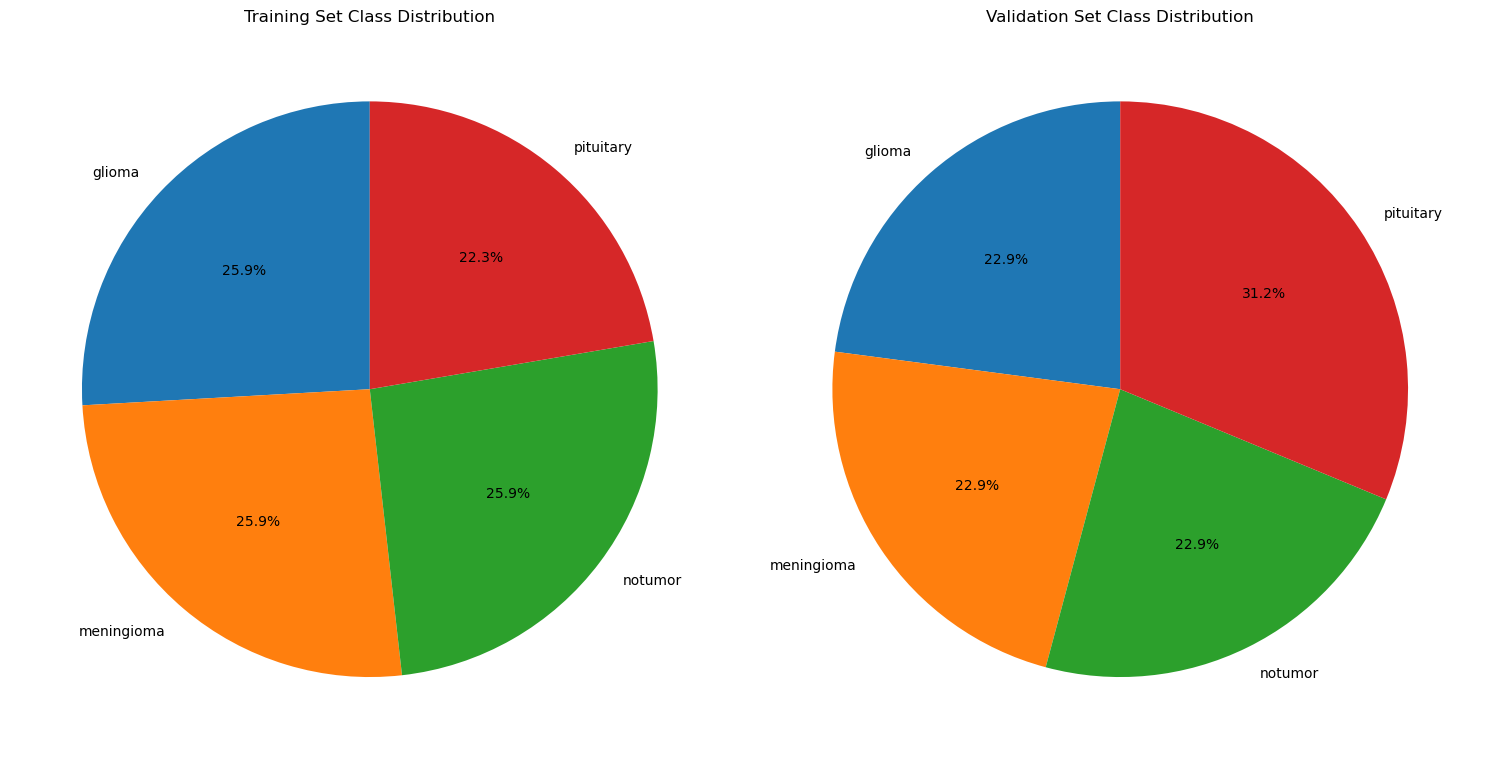

In [22]:
# Get the labels from the datasets
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

# Count the number of instances per class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Get the class names
class_names = dataset.classes

# Create a list of class counts for training and validation
train_class_counts = [train_counts[i] for i in range(len(class_names))]
val_class_counts = [val_counts[i] for i in range(len(class_names))]

# Create a pie chart
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].pie(train_class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Training Set Class Distribution')

ax[1].pie(val_class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Validation Set Class Distribution')

plt.tight_layout()
plt.show()